In [902]:
#Author:    Rui Ding
#Created:   04.14.2020

# Copula Bayesian Networks 

In [966]:
from sympy import *
import pandas as pd
import numpy as np
from scipy.stats import norm,mstats,spearmanr,multivariate_normal
from scipy import optimize
from scipy.optimize import Bounds
from collections import defaultdict 
from itertools import permutations
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#### Load Data 

In [704]:
Data = np.load('DJ_data.npy')

In [779]:
l = pd.read_table('Dow Jones 30.txt',header=None)
list_stocks=l.values.reshape(1,-1)[0]
names = list(list_stocks[:-1])

## Defining Various Copula Structures

### Frank-Archimedean Copula Density Calculation

In [960]:
def fr_copula(theta,u):
    d = len(u)
    prod = 1
    for i in range(d):
        prod*=np.exp(-theta*u[i])-1
    C = -(1/theta)*np.log(1+prod/(1/np.exp(theta) - 1)**(d-1))
    return C

In [78]:
x = symbols('x')
y = symbols('y')
z = symbols('z')
t = symbols('t')
C = -(1/t)*log(1+(1/exp(t*x)-1)*(1/exp(t*y)-1)*(1/exp(t*z)-1)/(1/exp(t) - 1)**2)
C

-log(1 + (-1 + exp(-t*x))*(-1 + exp(-t*y))*(-1 + exp(-t*z))/(-1 + exp(-t))**2)/t

In [80]:
c = diff(C,x,y,z)
c

t**2*(1 + 3*(1 - exp(-t*x))*(1 - exp(-t*y))*(1 - exp(-t*z))/((1 - (1 - exp(-t*x))*(1 - exp(-t*y))*(1 - exp(-t*z))/(1 - exp(-t))**2)*(1 - exp(-t))**2) + 2*(1 - exp(-t*x))**2*(1 - exp(-t*y))**2*(1 - exp(-t*z))**2/((1 - (1 - exp(-t*x))*(1 - exp(-t*y))*(1 - exp(-t*z))/(1 - exp(-t))**2)**2*(1 - exp(-t))**4))*exp(-t*x)*exp(-t*y)*exp(-t*z)/((1 - (1 - exp(-t*x))*(1 - exp(-t*y))*(1 - exp(-t*z))/(1 - exp(-t))**2)*(1 - exp(-t))**2)

In [82]:
f = lambdify([x,y,z,t],c, 'numpy')
f(1,0.3,0.2,1)

0.7563391667294173

In [62]:
def FAP(n):
    x = symbols('x')
    if n==1:
        y = 1/x
    else:
        x,z = FAP(n-1)
        y = z+diff(z,x)*(x-1)
    return x,y

In [69]:
def function_FAP(n):
    x,y = FAP(n)
    f = lambdify(x,y, 'numpy')
    return f

In [70]:
def frank_copula_density(u,theta):
    K = len(u)
    A = 1.0/(np.exp(-theta)-1)**(K-1)
    for i in range(K):
        A*=(np.exp(-theta*u[i])-1)
    A+=1
    P = function_FAP(K)
    c = (-theta)**(K-1)*np.exp(-theta*np.sum(u))*P(A)/(np.exp(-theta)-1)**(K-1)
    return c

In [483]:
frank_copula_density([1,0.3,0.2],1)

0.7563391667294171

### Gumbel Copula Density Calculation

In [962]:
def gu_copula(theta,u):
    d = len(u)
    s = 0
    for i in range(d):
        s+=(-np.log(u[i]))**theta
    C = np.exp(-s**(1.0/theta))
    return C

In [496]:
x = symbols('x')
y = symbols('y')
z = symbols('z')
t = symbols('t')
C = exp(-((-log(x))**t+(-log(y))**t+(-log(z))**t)**(1/t))
C

exp(-((-log(x))**t + (-log(y))**t + (-log(z))**t)**(1/t))

In [497]:
c = diff(C,x,y,z)
c

(-log(x))**t*(-log(y))**t*(-log(z))**t*((-log(x))**t + (-log(y))**t + (-log(z))**t)**(1/t)*(-2*t**2 - 3*t*((-log(x))**t + (-log(y))**t + (-log(z))**t)**(1/t) + 3*t - ((-log(x))**t + (-log(y))**t + (-log(z))**t)**(2/t) + 3*((-log(x))**t + (-log(y))**t + (-log(z))**t)**(1/t) - 1)*exp(-((-log(x))**t + (-log(y))**t + (-log(z))**t)**(1/t))/(x*y*z*((-log(x))**t + (-log(y))**t + (-log(z))**t)**3*log(x)*log(y)*log(z))

In [498]:
f = lambdify([x,y,z,t],c, 'numpy')
f(0.5,0.3,0.2,2)

1.7088202272167314

In [487]:
def GAP(n,theta):
    x = symbols('x')
    if n==1:
        y = x**(1.0/theta - 1)
    else:
        x,z = GAP(n-1,theta)
        y = x**(1.0/theta - 1)*z-theta*diff(z,x)
    return x,y

In [490]:
def function_GAP(n,theta):
    x,y = GAP(n,theta)
    f = lambdify(x,y, 'numpy')
    return f

In [491]:
def gumbel_copula_density(u,theta):
    K = len(u)
    A = np.sum((-np.log(u))**theta)

    P = function_GAP(K,theta)
    c = P(A)*np.exp(-A**(1.0/theta))
    for i in range(K):
        c*=(-np.log(u[i]))**(theta-1) / u[i]
    return c

In [493]:
gumbel_copula_density([0.5,0.3,0.2],2)

1.708820227216731

### Clayton Copula Density Calculation

In [964]:
def cl_copula(theta,u):
    d = len(u)
    s = np.sum(np.array(u)**(-theta))
    C = (s-d+1)**(-1.0/theta)
    return C

In [503]:
x = symbols('x')
y = symbols('y')
z = symbols('z')
t = symbols('t')
C = (x**(-t)+y**(-t)+z**(-t)-2)**(-1/t)
C

(-2 + z**(-t) + y**(-t) + x**(-t))**(-1/t)

In [504]:
c = diff(C,x,y,z)
c

x**(-t)*y**(-t)*z**(-t)*(2*t**2 + 3*t + 1)*(-2 + z**(-t) + y**(-t) + x**(-t))**(-1/t)/(x*y*z*(-2 + z**(-t) + y**(-t) + x**(-t))**3)

In [505]:
f = lambdify([x,y,z,t],c, 'numpy')
f(0.5,0.3,0.2,1)

1.3823999999999999

In [501]:
def clayton_copula_density(u,theta):
    K = len(u)
    c = (np.sum(np.array(u)**(-theta))+1-K)**(-1.0/theta-K)
    for i in range(K):
        c *= (u[i])**(-theta-1) * (1+theta*i)
    return c

In [502]:
clayton_copula_density([0.5,0.3,0.2],1)

1.3823999999999994

### Uniform Correlation Gaussian Copula Density Calculation

In [975]:
def g_copula(rho,u):
    K = len(u)
    sig = np.ones((K,K))*rho
    for i in range(K):
        sig[i][i] = 1
    dist = multivariate_normal(mean = np.zeros(K), cov=sig)
    v = np.array([norm.ppf(u_i) for u_i in u])
    return dist.cdf(v)

In [101]:
def gaussian_copula_density(u,rho):
    K = len(u)
    sig = np.ones((K,K))*rho
    for i in range(K):
        sig[i][i] = 1
    sig_inv = np.linalg.inv(sig)
    I = np.eye(K)
    v = np.array([[norm.ppf(u_i) for u_i in u]])
    a = np.dot(np.dot(v,sig_inv-I),v.T)
    c = np.exp(-0.5*a)/np.sqrt(np.linalg.det(sig))
    return c[0][0]

In [106]:
gaussian_copula_density([0.8,0.3,0.2],0.5)

0.6501828259476572

### Copula Density Ratio Calculation and Likelihood Evaluation

In [506]:
def copula_ratio(u,p,copula = 'Gaussian'):
    if copula=="Gaussian":
        r_c = gaussian_copula_density(u,p)/gaussian_copula_density(u[1:],p)
    elif copula=="Frank-Archimedean":
        r_c = frank_copula_density(u,p)/frank_copula_density(u[1:],p)
    elif copula == "Gumbel-Archimedean":
        r_c = gumbel_copula_density(u,p)/gumbel_copula_density(u[1:],p)
    elif copula == "Clayton-Archimedean":
        r_c = clayton_copula_density(u,p)/clayton_copula_density(u[1:],p)
    else:
        r_c = 1
    return r_c
def llh_local(p,F,u,c_type):
    M,N = F.shape
    l=0
    for m in range(M):
        r_c = copula_ratio(F[m,u],p,copula=c_type)
        l+=np.log(r_c)
    return l
def likelihood(P,F,f,G,c_type):
        M,N = F.shape
        l=0
        for i in range(N):
            l+=np.sum(np.log(f[:,i]))
        for i in range(len(G)):
            u = G[i]
            if len(u)>1:
                l+=llh_local(P[i],F,u,c_type)
            else:
                pass
        return l

## Copula Bayesian Network Class

#### Directed Network Graph Using Networkx

In [780]:
class CBN:  
    def __init__(self, N, G, param_c=0.5, param_f = [1.06,-0.2], c_type = 'Gaussian'):
        self.N = N
        self.construct_directed_graph(G)
        self.num_copula = len(G)
        self.local_copula = c_type
        self.p_0 = param_c
        self.param_c = np.ones(len(G))*param_c
        self.h_const = param_f[0]
        self.h_power = param_f[1]
    #Construct DiGraph from given dependency list
    def construct_directed_graph(self,G):
        self.G = G
        self.K = len(G)
        g = nx.DiGraph() 
        g.add_nodes_from(list(range(self.N)))
        for l in G:
            child = l[0]
            for i in range(1,len(l)):
                parent = l[i]
                g.add_edge(parent,child)
        self.graph = g
    def update_G(self):
        self.G = graph_to_list(self.graph)
        self.K = len(self.G)
        self.param_c = np.ones(self.K)*self.p_0
    def update_graph(self):
        self.K = len(self.G)
        self.param_c = np.ones(self.K)*self.p_0
        g = nx.DiGraph() 
        g.add_nodes_from(list(range(self.N)))
        for l in self.G:
            child = l[0]
            for i in range(1,len(l)):
                parent = l[i]
                g.add_edge(parent,child)
        self.graph = g
    def check_acyclic(self):
        flag = nx.is_directed_acyclic_graph(self.graph)
        return flag
    def draw_network(self,names=None):
        if names==None:
            nx.draw(self.graph,with_labels=True)
        else:
            keys = sorted(self.graph.nodes)
            mapping = {}
            for i in range(len(keys)):
                mapping[keys[i]] = names[i]

            H = nx.relabel_nodes(self.graph, mapping)
            nx.draw(H,with_labels=True)
        plt.draw()
        plt.show()
    def marginal_density_estimate(self,D):
        M = len(D)
        N = len(D[0])
        self.N = N
        F = np.zeros((M,N))
        f = np.zeros((M,N))
        for i in range(N):
            x = D[:,i]
            delta = 1.0/(4*M**0.25*np.sqrt(np.log(M)*np.pi))
            x_ = mstats.winsorize(x, limits=[delta, delta]).data
            s = np.std(x)
            h = self.h_const*s*M**(self.h_power)
            for j in range(M):
                F[j,i] = np.sum(1.0*(x<=x_[j]))/(M+1)
                f[j,i] = (1.0/(M*h))*np.sum(np.exp(-0.5*(x-D[j,i])**2)/h**2)/np.sqrt(2*np.pi)
        self.D = D
        self.F = F
        self.f = f
        self.M = M
        return F,f 
    def mle(self):
        p_0 = self.p_0
        neg_llh_local = lambda x,F,u,c: -llh_local(x,F,u,c)
        if self.local_copula=='Frank-Archimedean':
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.fmin_cg(neg_llh_local, p_0, args=(self.F,u,self.local_copula),full_output = True)
                opt_p = results[0][0]
                self.param_c[i] = opt_p
                #opt_l = results[1]
        elif self.local_copula=='Gumbel-Archimedean':
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([1.0],[np.inf]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
        elif self.local_copula=='Clayton-Archimedean':
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([0.01],[np.inf]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
        else:
            for i in range(len(self.G)):
                u=self.G[i]
                results = optimize.minimize(neg_llh_local,[p_0],method='SLSQP',
                                        args=(self.F,u,self.local_copula), 
                                        bounds = Bounds([0.01],[0.99]),
                                        options={'disp': True})
                opt_p = results.x[0]
                self.param_c[i] = opt_p
                #opt_l = results.fun
        
        self.likelihood = likelihood(self.param_c,self.F,self.f,self.G,self.local_copula)
        self.BIC = -2*self.likelihood+np.log(self.N)*self.K
        return self.param_c, self.likelihood, self.BIC
    

#### Helper Functions

In [821]:
def scoring(cbn):
    #F,f = cbn.marginal_density_estimate(D)
    opt_p,l,s = cbn.mle()
    return -s
def graph_to_list(g):
    d = {}
    for e in list(g.edges):
        if e[1] not in d.keys():
            d[e[1]] = [e[0]]
        else:
            d[e[1]].append(e[0])
    G = []
    for key in d.keys():
        l = d[key]
        full = [key]+list(l)
        G.append(full)
    return G

### Hill Climbing Search 

In [839]:
def HCS(D,N,p_0,copula,cur = []):
    E = list(permutations(range(N), r=2))
    cbn = CBN(N,cur,param_c = p_0, c_type = copula)
    F,f = cbn.marginal_density_estimate(D)
    g_old = cbn.graph
    g_opt = g_old
    score_old = scoring(cbn)
    score_opt = score_old
    start = True
    if not nx.is_directed_acyclic_graph(g_old):
        print('Input graph is cyclic.')
        return g_old,cur
    while score_opt>score_old or start:
        start=False
        score_old = score_opt
        g_old = g_opt
        for e in E:
            A = []
            if e in g_old.edges:
                A = ['revert','delete']
            elif e[::-1] in g_old.edges:
                pass
            else:
                A = ['add']
            for a in A:
                g = g_old.copy()
                if a=='delete':
                    g.remove_edge(e[0],e[1])
                elif a=='revert':
                    g.remove_edge(e[0],e[1])
                    g.add_edge(e[1],e[0])
                else:
                    g.add_edge(e[0],e[1])
                cbn.graph = g
                cbn.update_G()
                if cbn.check_acyclic():
                    score = scoring(cbn)
                    if score>score_opt:
                        g_opt = g
                        score_opt = score
                    else:
                        pass
                else:
                    continue
    cbn.graph = g_opt
    cbn.update_G()
    #F,f = cbn.marginal_density_estimate(D)
    opt_p,l,s = cbn.mle()
    print('Optimal likelihood: '+str(l))
    print('Optimal BIC: '+str(s))
    return cbn 

### Spearman's Rho Proxied Search 

In [876]:
def SPS(D,N,p_0,copula,nbhd = 2, cur = []):
    cbn = CBN(N,cur,param_c = p_0, c_type = copula)
    F,f = cbn.marginal_density_estimate(D)
    S_R = spearmanr(F,axis=0)[0]
    E = []
    for i in range(N):
        r = np.abs(S_R[i])
        top = r.argsort()[-nbhd-1:][::-1]
        for j in range(nbhd):
            E.append((i,top[j+1]))
            E.append((top[j+1],i))
    E = set(E)
    print(E)
    g_old = cbn.graph
    g_opt = g_old
    score_old = scoring(cbn)
    score_opt = score_old
    start = True
    if not nx.is_directed_acyclic_graph(g_old):
        print('Input graph is cyclic.')
        return g_old,cur
    while score_opt>score_old or start:
        start=False
        score_old = score_opt
        g_old = g_opt
        for e in E:
            A = []
            if e in g_old.edges:
                A = ['revert','delete']
            elif e[::-1] in g_old.edges:
                pass
            else:
                A = ['add']
            for a in A:
                g = g_old.copy()
                if a=='delete':
                    g.remove_edge(e[0],e[1])
                elif a=='revert':
                    g.remove_edge(e[0],e[1])
                    g.add_edge(e[1],e[0])
                else:
                    g.add_edge(e[0],e[1])
                cbn.graph = g
                cbn.update_G()
                if cbn.check_acyclic():
                    score = scoring(cbn)
                    if score>score_opt:
                        g_opt = g
                        score_opt = score
                    else:
                        pass
                else:
                    continue
    cbn.graph = g_opt
    cbn.update_G()
    #F,f = cbn.marginal_density_estimate(D)
    opt_p,l,s = cbn.mle()
    print('Optimal likelihood: '+str(l))
    print('Optimal BIC: '+str(s))
    return cbn 

## Testing

In [881]:
#Data input
N = 4
M = 1500
D = Data[:M,:N]
label = names[:N]

In [851]:
#Initial structure
G =[[0,1],[2,1]]
copula = 'Clayton-Archimedean'
p_0 = 1.0

In [852]:
cbn = CBN(N,G,param_c = p_0, c_type = copula)

In [853]:
cbn.check_acyclic()

True

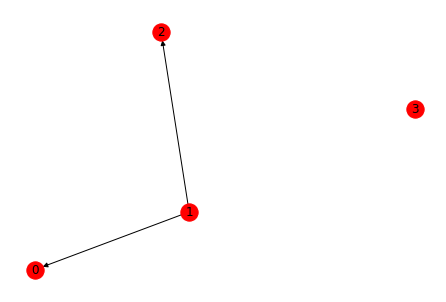

In [854]:
cbn.draw_network()

In [855]:
F,f = cbn.marginal_density_estimate(D)

In [856]:
likelihood([p_0,p_0],F,f,G,c_type=copula)

93395.72615646306

In [857]:
cbn.mle()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -171.7133237464996
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -138.9499818775585
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5


(array([0.74317053, 0.65089456]), 93437.47559815596, -186872.17860758968)

In [858]:
scoring(cbn)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -171.7133237464996
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -138.9499818775585
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5


186872.17860758968

### Performing Hill Climbing Search for Optimal Structure

In [833]:
cbn_opt = HCS(D,N,p_0,copula,cur = [])

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -171.71332374649927
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -200.36972069829343
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -227.02960789663132
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -171.7133237464996
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -138.9499818775585
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -171.7133237464996
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -236.87911724553572
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -227.02960789663132
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -245.01376665663562
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -268.9508467866629
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -236.87911724553572
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.6271319661162
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -227.02960789663132
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -222.67976544211012
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -276.20058338145185
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -227.02960789663132
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -225.76343153164026
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -276.20058338145185
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -268.9508467866629
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -171.71332374649927
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -200.36972069829343
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -227.02960789663132
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -225.76343153164026
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -276.20058338145185
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimal likelihood: 93855.80591534161
Optimal BIC: -187707.45294759987


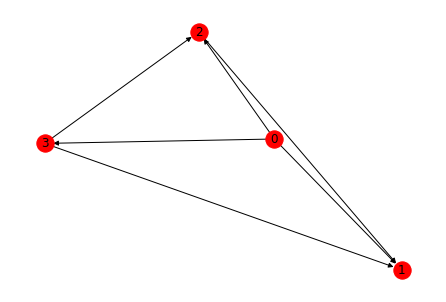

In [834]:
#optimal structure
cbn_opt.draw_network()

In [835]:
cbn_opt.check_acyclic()

True

In [836]:
#Optimal local copula and their parameters
cbn_opt.G,cbn_opt.param_c

([[3, 0], [1, 0, 2, 3], [2, 0, 3]],
 array([0.90516719, 0.54943492, 0.76126358]))

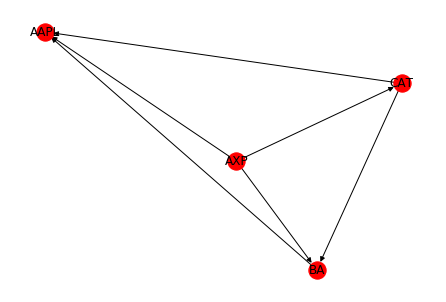

In [837]:
cbn_opt.draw_network(names=label)

#### Generalized Tail Dependency Measure Based on Learned Structure 

In [1025]:
def low_tail(theta,u,q,copula):
    if copula=='Gaussian':
        return g_copula(theta,np.ones(len(u))*q)
    elif copula=='Frank-Archimedean':
        return fr_copula(theta,np.ones(len(u))*q)
    elif copula=='Gumbel-Archimedean':
        return gu_copula(theta,np.ones(len(u))*q)
    elif copula=='Clayton-Archimedean':
        return cl_copula(theta,np.ones(len(u))*q)
    else:
        return q**2
def gen_low_tail_corr(theta,u,q,copula):
    l = np.array(label)
    print(label[u[0]]+' | '+','.join(list(l[u[1:]])))
    td = low_tail(theta,u,q,copula)/(low_tail(theta,u[1:],q,copula))
    print(td)
    return td

In [1027]:
q = 0.05
for i in range(cbn_opt.K):
    gen_low_tail_corr(cbn_opt.param_c[i],cbn_opt.G[i],q,cbn_opt.local_copula)

CAT | AXP
0.48265647832077324
AAPL | AXP,BA,CAT
0.6127964783136256
BA | AXP,CAT
0.6012046849019698


### Performing Full Network Search Guided by Spearman's Rho Proxy

In [885]:
N = 29
M = 250
D = Data[-M:,:N]
label = names[:N]

In [886]:
copula = 'Clayton-Archimedean'
p_0 = 1.0

In [887]:
cbn_prox = SPS(D,N,p_0,copula,nbhd=1,cur = [])

{(11, 16), (21, 14), (3, 15), (5, 6), (0, 7), (22, 19), (17, 25), (9, 4), (19, 22), (18, 8), (18, 23), (12, 20), (4, 9), (20, 12), (27, 20), (13, 3), (28, 23), (26, 3), (23, 2), (12, 24), (2, 23), (13, 7), (1, 10), (4, 1), (20, 27), (16, 11), (3, 13), (15, 3), (1, 4), (10, 1), (16, 19), (3, 26), (6, 5), (13, 23), (7, 0), (25, 17), (19, 16), (23, 28), (7, 13), (8, 18), (14, 21), (24, 12), (23, 13), (23, 18)}
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.15011591385673
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.9825328230493
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407629854
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187742611
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980313
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407629854
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407629854
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264727732
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980313
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377371753
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -32.64734110202099
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.5294482808309
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680406
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.9825328230493
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382703
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276578767
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680406
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.15011591385673
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -163.87310086026662
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.3598623576307
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323109914
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -87.65011897692148
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.4644978913272
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680406
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276578767
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -165.4134240559162
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792381333
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -32.64734110202099
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -32.647341102062505
            Iterations: 4
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -78.14132381250366
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383238
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evalua

            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimizat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383238
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.15011591385673
            Iterations: 2
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.4644978913272
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680406
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498764676
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -94.18494215452438
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -78.14132381250366
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.87820263892516
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -107.36269429704188
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323109914
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.68866922022124
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382703
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894588154
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.5294482808309
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383238
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407629854
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -165.4134240559162
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.15011591385673
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.15011591385673
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.15011591385673
            Iterations: 2
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -94.18494215452438
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -115.68866922022124
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.87820263892516
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -165.4134240559162
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -32.647341102062505
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.15011591385673
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.15011591385673
            Iterations: 2
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -32.647341102062505
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -32.647341102062505
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -32.647341102062505
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.15011591385673
            Iterations: 2
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894588154
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -133.46914498859758
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -44.29621996980261
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70.92176264735245
            Iterations: 5
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -75.83396894599157
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -77.28661377359897
            Iterations: 5
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -59.27674276584069
            Iterations: 4
            Function evaluations: 14
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.963555615355254
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -89.81753441382635
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -32.647341102062505
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -67.74420407633481
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.03060792395965
            Iterations: 6
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -73.35986235767902
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -32.647341102062505
            Iterations: 4
            Function evaluations: 13
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.49881557775278
            Iterations: 3
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evaluations: 12
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -136.52944828106774
            Iterations: 5
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -179.98253282334167
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.64153493998326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.29546556383518
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -105.93408558169799
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -65.45584323111068
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -38.15011591385673
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -82.82883447680308
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -42.93563187748923
            Iterations: 3
            Function evaluat

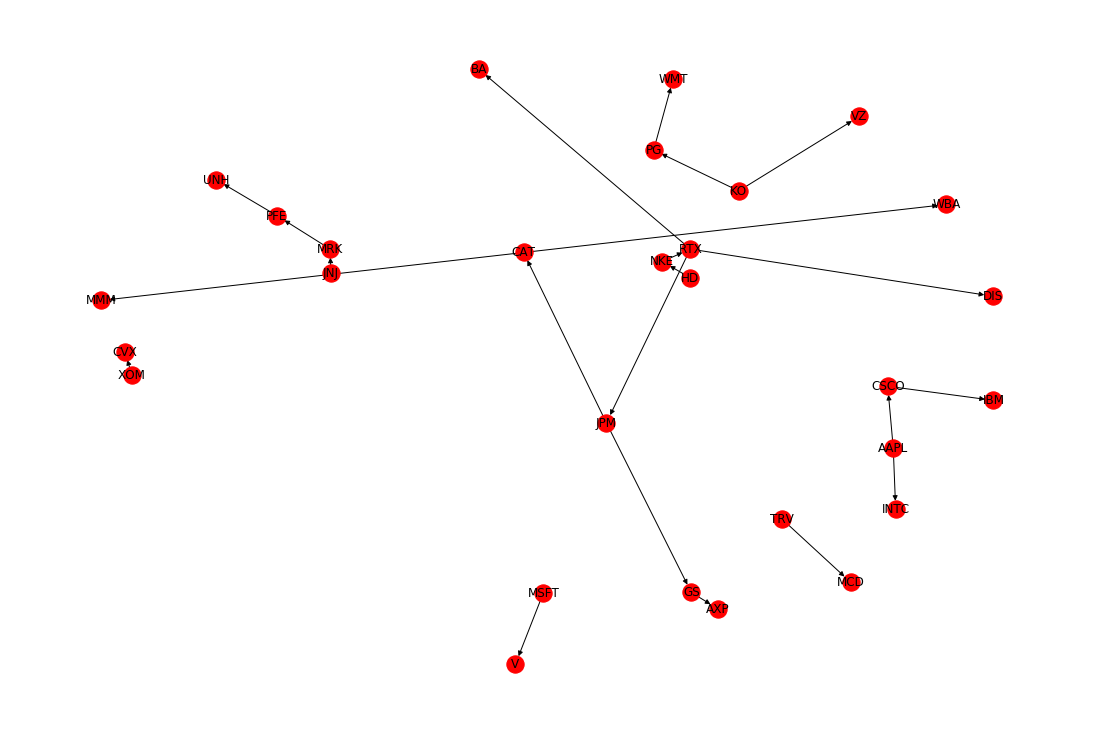

In [900]:
plt.figure(figsize=(15,10))
nx.drawing.layout.spring_layout(cbn_prox.graph)
cbn_prox.draw_network(names=label)

#### Generalized Tail Dependency Measure Based on Learned Structure 

In [1028]:
q=0.05
for i in range(cbn_prox.K):
    gen_low_tail_corr(cbn_prox.param_c[i],cbn_prox.G[i],q,cbn_prox.local_copula)

INTC | AAPL
0.6831413658710389
CSCO | AAPL
0.6455793712000945
MMM | CAT
0.6512295750873612
WBA | CAT
0.5376624555043812
IBM | CSCO
0.6416645755128524
CVX | XOM
0.7713509024552396
AXP | GS
0.7196175192183574
NKE | HD
0.6097761421901665
MRK | JNJ
0.5094610519567212
PG | KO
0.6746261230610389
VZ | KO
0.5239120967466386
GS | JPM
0.8256379768670756
CAT | JPM
0.6919000511371991
PFE | MRK
0.5381111180486045
V | MSFT
0.7728985936935386
RTX | NKE
0.6317331451949625
UNH | PFE
0.47307834854019754
WMT | PG
0.5323427843671932
MCD | TRV
0.6240560853392564
JPM | RTX
0.7058501570605096
DIS | RTX
0.5888165853627711
BA | RTX
0.5385714154175736
